In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## Data

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe (1/0) a term deposit (variable y).

This dataset provides the customer information. It includes 41188 records and 21 fields.

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

16 - emp.var.rate: employment variation rate - (numeric)

17 - cons.price.idx: consumer price index - (numeric)

18 - cons.conf.idx: consumer confidence index - (numeric)

19 - euribor3m: euribor 3 month rate - (numeric)

20 - nr.employed: number of employees - (numeric)

y - has the client subscribed a term deposit? (binary: '1','0')

In [5]:
data = pd.read_csv('https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv')
data.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0


In [6]:
data.shape

(41188, 21)

In [7]:
data = data.dropna()
print(data.shape)
print(list(data.columns))

(41188, 21)
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']


In [8]:
data.education.unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

In [9]:
#The education column of the dataset has many categories and we need to reduce the categories for a better modelling. The education column has the following categories:

In [10]:
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

In [11]:
# After grouping
data['education'].unique()

array(['Basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

# Data Exploration

In [12]:
data['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

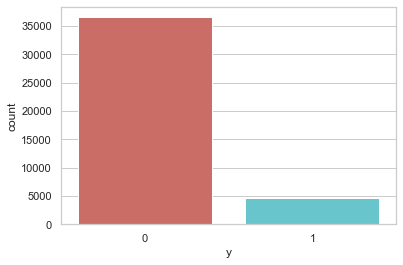

<Figure size 432x288 with 0 Axes>

In [13]:
sns.countplot(x='y',data=data, palette='hls')
plt.show()
#plt.savefig('count_plot')

In [14]:
#Let's get a sense of numbers across the two classes
data['y'].value_counts(normalize=True)

0    0.887346
1    0.112654
Name: y, dtype: float64

In [15]:
data.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


## Observations:


The average age of customers who bought the term deposit is higher than that of the customers who didn't.

The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale. Surprisingly, campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.

We can calculate categorical means for other categorical variables such as education and marital status to get a more detailed sense of our data.

In [16]:
data.groupby('job').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
job,,,,,,,,,,,
admin.,38.187296,254.312128,2.623489,954.319229,0.189023,0.015563,93.534054,-40.245433,3.550274,5164.125350,0.129726
blue-collar,39.555760,264.542360,2.558461,985.160363,0.122542,0.248995,93.656656,-41.375816,3.771996,5175.615150,0.068943
entrepreneur,41.723214,263.267857,2.535714,981.267170,0.138736,0.158723,93.605372,-41.283654,3.791120,5176.313530,0.085165
housemaid,45.500000,250.454717,2.639623,960.579245,0.137736,0.433396,93.676576,-39.495283,4.009645,5179.529623,0.100000
management,42.362859,257.058140,2.476060,962.647059,0.185021,-0.012688,93.522755,-40.489466,3.611316,5166.650513,0.112175
retired,62.027326,273.712209,2.476744,897.936047,0.327326,-0.698314,93.430786,-38.573081,2.770066,5122.262151,0.252326
self-employed,39.949331,264.142153,2.660802,976.621393,0.143561,0.094159,93.559982,-40.488107,3.689376,5170.674384,0.104856
services,37.926430,258.398085,2.587805,979.974049,0.154951,0.175359,93.634659,-41.290048,3.699187,5171.600126,0.081381
student,25.894857,283.683429,2.104000,840.217143,0.524571,-1.408000,93.331613,-40.187543,1.884224,5085.939086,0.314286


In [17]:
data.groupby('marital').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
marital,,,,,,,,,,,
divorced,44.899393,253.790330,2.61340,968.639853,0.168690,0.163985,93.606563,-40.707069,3.715603,5170.878643,0.103209
married,42.307165,257.438623,2.57281,967.247673,0.155608,0.183625,93.597367,-40.270659,3.745832,5171.848772,0.101573
single,33.158714,261.524378,2.53380,949.909578,0.211359,-0.167989,93.517300,-40.918698,3.317447,5155.199265,0.140041
unknown,40.275000,312.725000,3.18750,937.100000,0.275000,-0.221250,93.471250,-40.820000,3.313038,5157.393750,0.150000


In [18]:
data.groupby('education').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
education,,,,,,,,,,,
Basic,42.163910,263.043874,2.559498,974.877967,0.141053,0.191329,93.639933,-40.927595,3.729654,5172.014113,0.087029
high.school,37.998213,260.886810,2.568576,964.358382,0.185917,0.032937,93.584857,-40.940641,3.556157,5164.994735,0.108355
illiterate,48.500000,276.777778,2.277778,943.833333,0.111111,-0.133333,93.317333,-39.950000,3.516556,5171.777778,0.222222
professional.course,40.080107,252.533855,2.586115,960.765974,0.163075,0.173012,93.569864,-40.124108,3.710457,5170.155979,0.113485
university.degree,38.879191,253.223373,2.563527,951.807692,0.192390,-0.028090,93.493466,-39.975805,3.529663,5163.226298,0.137245
unknown,43.481225,262.390526,2.596187,942.830734,0.226459,0.059099,93.658615,-39.877816,3.571098,5159.549509,0.145003


In [19]:
pd.crosstab(data.job,data.y)

y,0,1
job,,
admin.,9070,1352
blue-collar,8616,638
entrepreneur,1332,124
housemaid,954,106
management,2596,328
retired,1286,434
self-employed,1272,149
services,3646,323
student,600,275


### Job vs Purchase

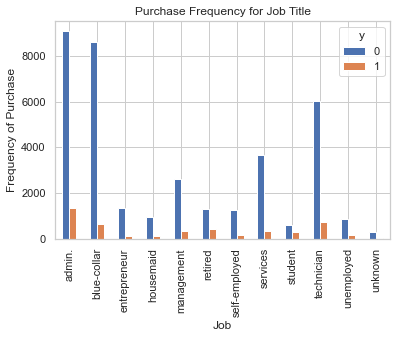

In [20]:
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
plt.show()

The frequency of purchase of the deposit depends a great deal on the job title. Thus, the job title can be a good predictor of the outcome variable.

In [21]:
table = pd.crosstab(data.marital,data.y)
table

y,0,1
marital,,
divorced,4136,476
married,22396,2532
single,9948,1620
unknown,68,12


In [23]:
#table.sum(0) # column wise addition
#table.sum(1) # row wise addition

In [22]:
table.div(table.sum(1).astype(float), axis=0)

y,0,1
marital,,
divorced,0.896791,0.103209
married,0.898427,0.101573
single,0.859959,0.140041
unknown,0.850000,0.150000


## 'Marital Status' vs Purchase

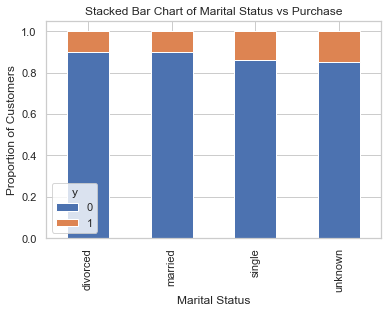

In [24]:
table = pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
plt.show()

marital status does not seem a strong predictor for the outcome variable.

### Education vs Purchase

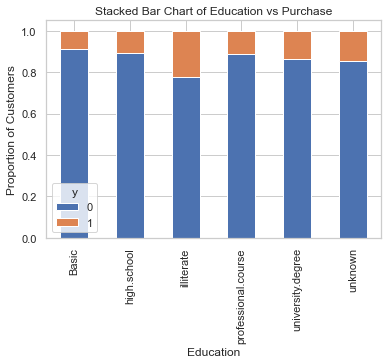

In [25]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
plt.show()

### Age Distribution of the customer

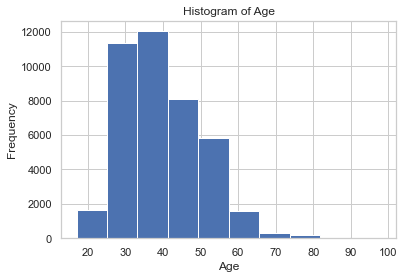

In [26]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()
#plt.savefig('hist_age')

The most of the customers of the bank in this dataset are in the age range of 30-40

### Poutcome vs Purchase

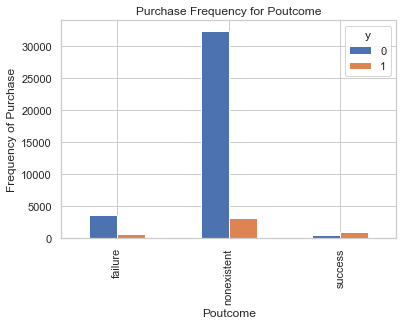

In [28]:
pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
plt.show()

Poutcome seems to be a good predictor of the outcome variable.

### Preprocessing

In [29]:
categorical_columns_list = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']


for columns in categorical_columns_list:
    cat_list = pd.get_dummies(data[columns], prefix=columns) # creating dummy variables
    data1=data.join(cat_list) #creating dummy variable and concatenating with the dataframes
    data=data1

In [30]:
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,44,blue-collar,married,Basic,unknown,yes,no,cellular,aug,thu,...,0,0,0,0,1,0,0,0,1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,0,0,1,0,0,0,0,0,1,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,0,0,0,0,1,0,0,0,0,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,0,0,1,0,0,0,0,0,1,0
4,55,retired,married,Basic,no,yes,no,cellular,aug,fri,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,59,retired,married,high.school,unknown,no,yes,telephone,jun,thu,...,0,0,0,0,1,0,0,0,1,0
41184,31,housemaid,married,Basic,unknown,no,no,telephone,may,thu,...,0,0,0,0,1,0,0,0,1,0
41185,42,admin.,single,university.degree,unknown,yes,yes,telephone,may,wed,...,0,0,0,0,0,0,1,0,1,0
41186,48,technician,married,professional.course,no,no,yes,telephone,oct,tue,...,1,0,0,0,0,1,0,0,1,0


discard the columns which have been converted in to dummy variables

In [32]:
data_vars = data.columns.values.tolist()

to_keep = [column for column in data_vars if column not in categorical_columns_list]
to_keep

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'y',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'education_Basic',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'education_unknown',
 'default_no',
 'default_unknown',
 'default_yes',
 'housing_no',
 'housing_unknown',
 'housing_yes',
 'loan_no',
 'loan_unknown',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'month_apr',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'day_of_week_fri',
 'day_of_week_mon',
 'day_of_week_thu',
 'day_of_

Dataset only numerical and dummy variable

In [33]:
data_final=data[to_keep]
data_final

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,44,210,1,999,0,1.4,93.444,-36.1,4.963,5228.1,...,0,0,0,0,1,0,0,0,1,0
1,53,138,1,999,0,-0.1,93.200,-42.0,4.021,5195.8,...,0,0,1,0,0,0,0,0,1,0
2,28,339,3,6,2,-1.7,94.055,-39.8,0.729,4991.6,...,0,0,0,0,1,0,0,0,0,1
3,39,185,2,999,0,-1.8,93.075,-47.1,1.405,5099.1,...,0,0,1,0,0,0,0,0,1,0
4,55,137,1,3,1,-2.9,92.201,-31.4,0.869,5076.2,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,59,222,1,999,0,1.4,94.465,-41.8,4.866,5228.1,...,0,0,0,0,1,0,0,0,1,0
41184,31,196,2,999,0,1.1,93.994,-36.4,4.860,5191.0,...,0,0,0,0,1,0,0,0,1,0
41185,42,62,3,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,0,0,0,1,0,1,0
41186,48,200,2,999,0,-3.4,92.431,-26.9,0.742,5017.5,...,1,0,0,0,0,1,0,0,1,0


## Model Building

In [36]:
X = data_final.loc[:, data_final.columns != 'y']
y = data_final.loc[:, data_final.columns == 'y']

In [37]:
X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=0)

In [38]:
logreg = LogisticRegression()
logreg.fit(X_train,Y_train)

C:\Users\ACER\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\ACER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [39]:
y_pred = logreg.predict(x_test)

In [40]:
from sklearn import metrics
print(metrics.accuracy_score(y_test,y_pred))

0.914829562008352


In [41]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      9156
           1       0.67      0.45      0.54      1141

    accuracy                           0.91     10297
   macro avg       0.80      0.71      0.75     10297
weighted avg       0.91      0.91      0.91     10297



#### Threshold

In [54]:
Threshold=0.43

preds = np.where(logreg.predict_proba(x_test)[:,1]>Threshold,1,0)

# preds1 = logreg.predict_proba(x_test)[:,1]S

threshold_score = pd.DataFrame(data=[metrics.accuracy_score(y_test, preds), 
                                     metrics.recall_score(y_test, preds),
                                     metrics.precision_score(y_test, preds),
                                     metrics.roc_auc_score(y_test, preds)],
                              index=["accuracy", "recall", "precision", "roc_auc_score"],columns=['Values'])
threshold_score

,Values
accuracy,0.910265
recall,0.505697
precision,0.615795
roc_auc_score,0.733189


#### ROC vs AUC Curve

Text(0.5, 1.0, 'ROC Curve')

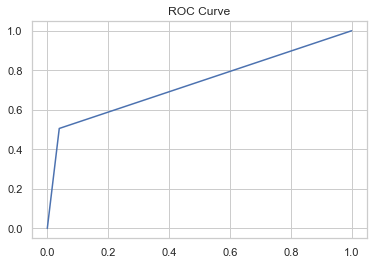

In [56]:
fpr,tpr,threshold = metrics.roc_curve(y_test,preds)
plt.plot(fpr,tpr)
plt.title('ROC Curve')